In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# need to install

In [ ]:
! pip install shap

# library

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
from scipy.stats import pearsonr
import shap
import joblib
from joblib import dump, load

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import LinearRegression
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def evaluate_models(models, model_names, X_data, y_data, for_what):
    """
    Evaluate machine learning models and return a DataFrame with performance metrics.

    Parameters:
    - models (list): List of trained model instances.
    - model_names (list): List of names corresponding to the models.
    - X_data (pd.DataFrame): Feature data for evaluation.
    - y_data (pd.Series or np.array): True target values for evaluation.

    Returns:
    - pd.DataFrame: DataFrame containing R-squared, MSE, MAE, and RMSE for each model.
    """

    # Initialize lists to store results
    r2_values = []
    mse_values = []
    mae_values = []
    rmse_values = []
    cv_values = []

    # Calculate metrics for each model
    for model in models:
        y_pred = model.predict(X_data)

        r2 = r2_score(y_data, y_pred)#.round(3)
        mse = mean_squared_error(y_data, y_pred)#.round(3)
        mae = mean_absolute_error(y_data, y_pred)#.round(3)
        rmse = np.sqrt(mse)#.round(3)
        cv_value = (rmse/(np.absolute((np.array(y_data).flatten().mean(axis=0))))).round(3)

        r2_values.append(r2)
        mse_values.append(mse)
        mae_values.append(mae)
        rmse_values.append(rmse)
        cv_values.append(cv_value)

    # Create a DataFrame with the results
    results_df = pd.DataFrame({
        'Model '+for_what : model_names,
        'R2': r2_values,
    #    'MSE': mse_values,
     #   'MAE': mae_values,
        'RMSE': rmse_values,
        'CV' : cv_values
    })

    return results_df

In [ ]:
def evaluate_models_all(models, model_names, X_data, y_data, x_test, y_test):
    """
    Evaluate machine learning models and return a DataFrame with performance metrics.

    Parameters:
    - models (list): List of trained model instances.
    - model_names (list): List of names corresponding to the models.
    - X_data (pd.DataFrame): Feature data for evaluation.
    - y_data (pd.Series or np.array): True target values for evaluation.

    Returns:
    - pd.DataFrame: DataFrame containing R-squared, MSE, MAE, and RMSE for each model.
    """

    # Initialize lists to store results
    r2_values_train = []
    rmse_values_train = []
    # cv_values_train= []

    r2_values_test = []
    rmse_values_test = []
    # cv_values_test = []

    # Calculate metrics for each model
    for model in models:
        y_pred_train = model.predict(X_data)
        y_pred_test = model.predict(x_test)
        r2_train = r2_score(y_data, y_pred_train)#.round(3)
        rmse_train = np.sqrt(mean_squared_error(y_data, y_pred_train))#.round(3)
        # cv_value_train = (rmse_train/(np.absolute((np.array(y_data).flatten().mean(axis=0))))).round(3)
        r2_test = r2_score(y_test, y_pred_test)#.round(3)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))#.round(3)
        # cv_value_test = (rmse_test/(np.absolute((np.array(y_test).flatten().mean(axis=0))))).round(3)

        r2_values_train.append(r2_train)
        rmse_values_train.append(rmse_train)
        # cv_values_train.append(cv_value_train)
        r2_values_test.append(r2_test)
        rmse_values_test.append(rmse_test)
        # cv_values_test.append(cv_value_test)

    # Create a DataFrame with the results
    results_df = pd.DataFrame({
        'ML Model': model_names,
        'R2 train': r2_values_train,
        'R2 test': r2_values_test,
        'RMSE train': rmse_values_train,
        'RMSE test': rmse_values_test,
        # 'CV train' : cv_values_train,
        # 'CV test' : cv_values_test,
    })

    return results_df

In [ ]:
# Create a heatmap for the pearsons coefficient
def heatmap_corrvalue (df, corr_method , title):
    corr = df.corr(method=corr_method).round(2)   #, 'feel_bright'

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    total_columns = df.columns.shape[0]
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(total_columns+1,total_columns))

    plt.xticks(rotation=90, fontsize=total_columns)
    plt.title('correlation map : '+ '(' + corr_method + ') '+title , fontsize=total_columns)
    plt.yticks(fontsize=total_columns,rotation=90 )

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220,10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask,cmap="coolwarm", vmin=-1, vmax=1, center=0, cbar=True, annot =True,
                square=True, linewidths=.5, annot_kws={"size": (total_columns)})
    plt.show()
    plt.clf()
# Create a heatmap for the pearsons coefficient

def heatmap_corrvalue_p (df, title):
    corr = df.corr().round(2)   #, 'feel_bright'
    p_values = pd.DataFrame(index=corr.index, columns=corr.columns)
    for col in corr.columns:
        for row in corr.index:
            r, p = pearsonr(df[col], df[row])
            p_values.at[row, col] = p
    # Round the p-values for better display
    p_values = p_values.astype(float).round(4)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    total_columns = df.columns.shape[0]
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(total_columns+1,total_columns))
    plt.xticks(rotation=90, fontsize=total_columns)
    plt.title('correlation map : '+title , fontsize=total_columns)
    plt.yticks(fontsize=total_columns,rotation=90 )

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220,10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(p_values, mask=mask,cmap="coolwarm", vmin=0, vmax=0.05, center=0.025, cbar=True, annot =True,
                square=True, linewidths=.5, annot_kws={"size": (total_columns)})
    plt.show()
    plt.clf()

In [ ]:
def estimate_predictions(models, model_names, x_train, y_train,names):
    # if len(models) != len(model_names):
    #     raise ValueError("Length of models and model_names must be the same")

    # Initialize the result DataFrame with the actual y_train values
    result_df = pd.DataFrame(np.array(y_train).flatten(), columns=['y_' + names])

    # Add the predicted values for each model
    for model, name in zip(models, model_names):
        result_df[name] = model.predict(x_train).reshape(-1,1)

    return result_df

# Function to compute R², RMSE, and MSE for given true and predicted values
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    cv_value = rmse/y_true.mean(axis=0)
    return r2, rmse, cv_value

def evaluate_predictions(df, y_true_name, condition_name ):
    # Initialize an empty list to store the results
    results = []

    # Loop through each y_pred column and calculate the metrics
    for col in df.columns:
        if col != y_true_name:
            r2, rmse, cv_value = calculate_metrics(df[y_true_name], df[col])
            results.append({condition_name: col, 'R2': r2,'RMSE': rmse,  'CV': cv_value})

    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

def check_train_test ( model_list,model_name, x,y ,train_percent, random_use):
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = (train_percent/100),
                                                    shuffle = True, random_state= random_use )
    print("Train ")
    print( str(model_name[0])+ '  ' +  str(model_list[0].score(x_train, y_train)))
    print( str(model_name[1])+  '  ' + str(model_list[1].score(x_train, y_train)))
    print( str(model_name[2])+   '  ' + str(model_list[2].score(x_train, y_train)))
    print(" ")
    print("Test ")
    print(str(model_name[0])+  '  ' + str(model_list[0].score(x_test, y_test)))
    print(str(model_name[1])+  '  ' + str(model_list[1].score(x_test, y_test)))
    print(str(model_name[2])+  '  ' + str(model_list[2].score(x_test, y_test)))

# Background Knowledge

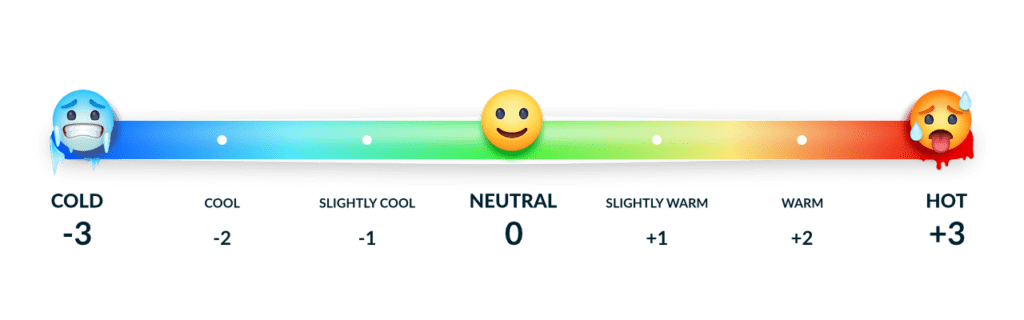

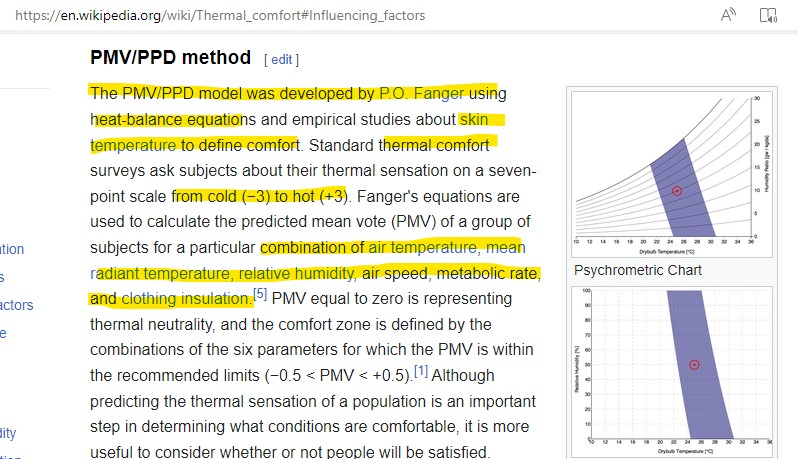

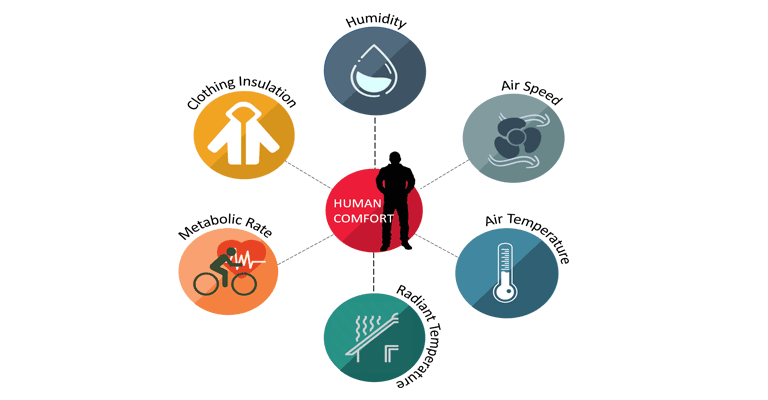

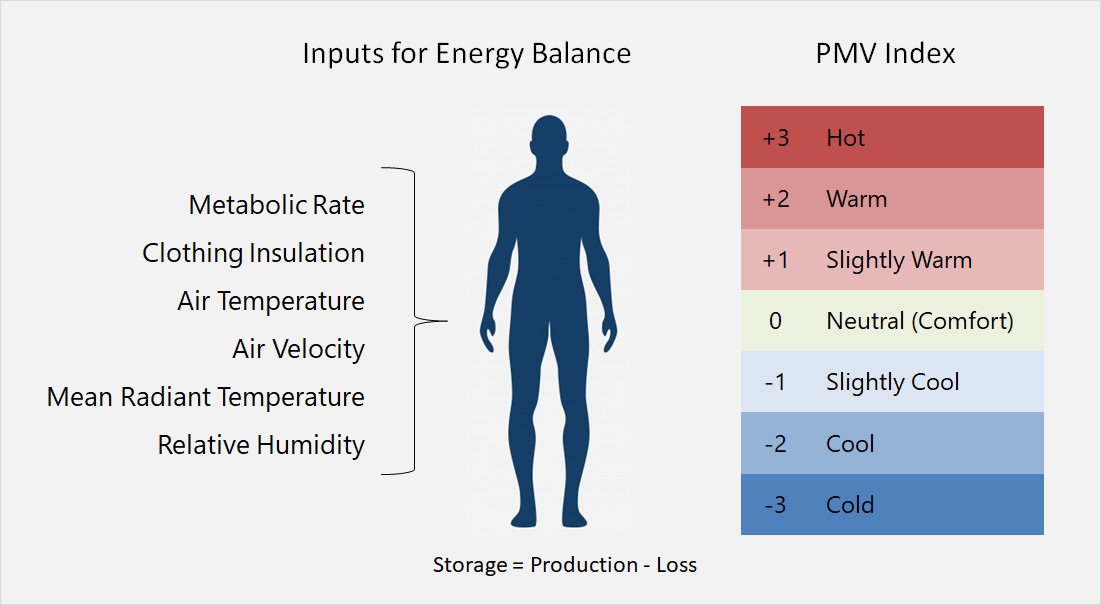

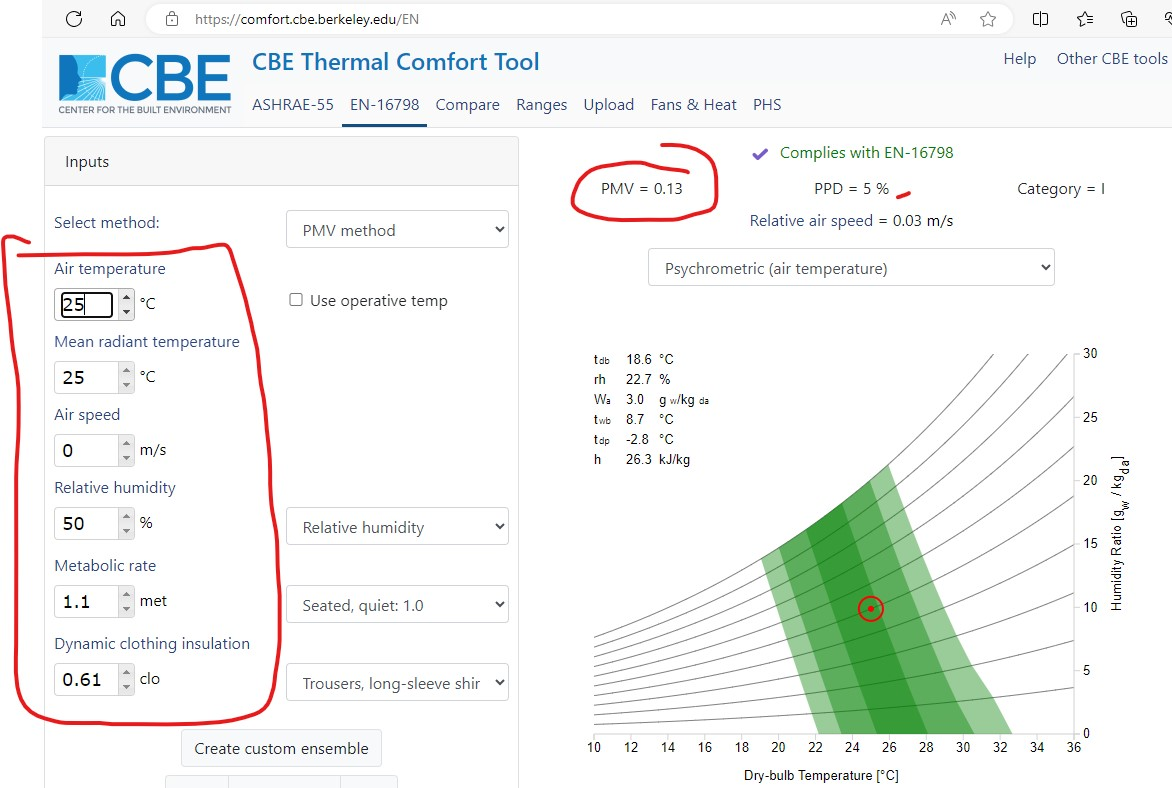

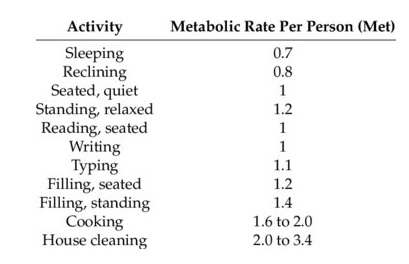

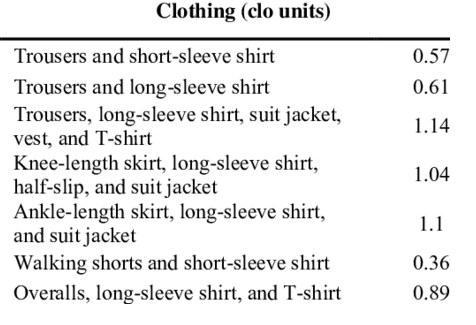

# Data Defining

In [ ]:
# if we run it using data from Github
df = pd.read_csv('https://raw.githubusercontent.com/rayunacute/MVDA/refs/heads/main/PMV%20PPD/PMV%20example%20data.csv')
df.describe()

,Air Temp.,radiant temp.,air velocity,Relative.Humid,Metabolic.Rate,cloth.thick.rate,thermal sensation
count,630697.000000,630697.000000,630697.000000,630697.000000,630697.000000,630697.000000,630697.000000
mean,21.506338,21.700489,0.099925,38.757755,1.429113,0.741664,-0.257738
std,2.290107,2.606948,0.070668,18.493891,0.341060,0.185883,0.818509
min,18.000000,18.000000,0.000000,15.000000,1.000000,0.500000,-3.000000
25%,20.000000,19.000000,0.050000,25.000000,1.100000,0.570000,-0.780000
50%,22.000000,22.000000,0.100000,40.000000,1.400000,0.670000,-0.150000
75%,24.000000,24.000000,0.150000,50.000000,1.800000,0.960000,0.360000
max,25.000000,26.000000,0.200000,70.000000,2.000000,1.000000,1.610000


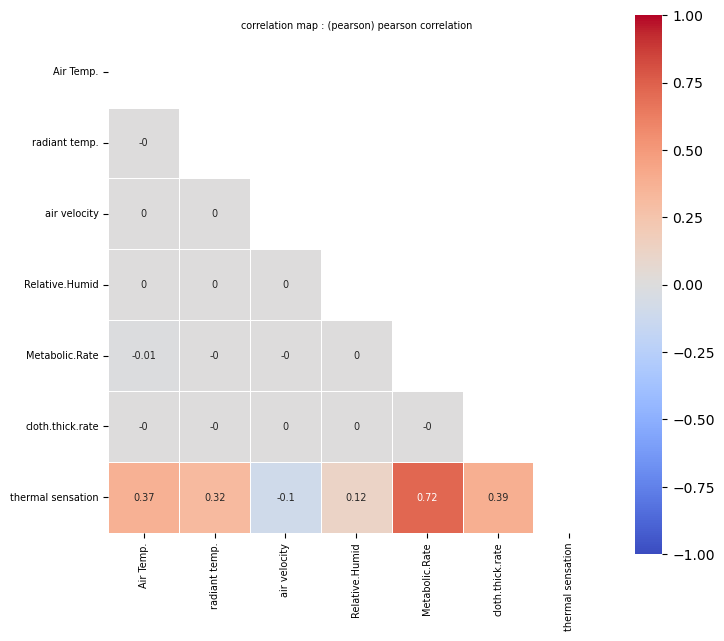

<Figure size 640x480 with 0 Axes>

In [ ]:
heatmap_corrvalue(df, 'pearson','pearson correlation')

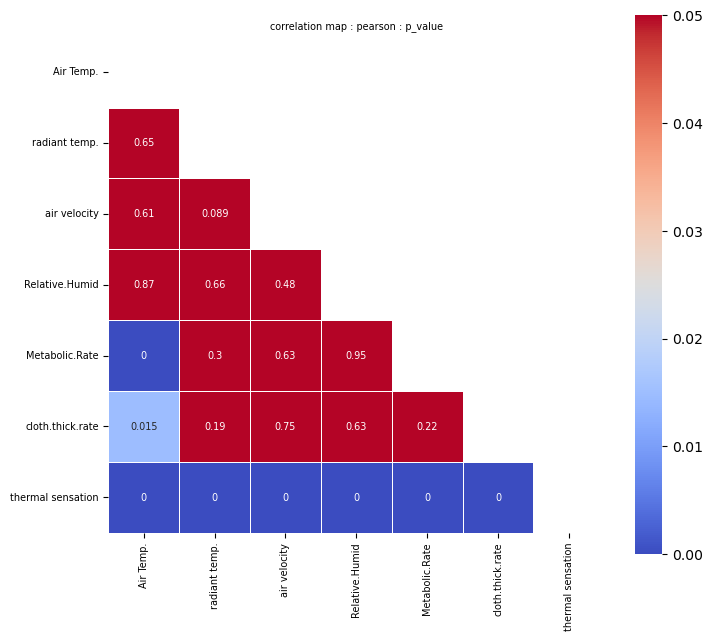

<Figure size 640x480 with 0 Axes>

In [ ]:
heatmap_corrvalue_p(df, 'pearson : p_value')

In [ ]:
#clean data_input from outliers
target_col = 'thermal sensation'
train_percent = 85

data_input = df.copy().sort_values(target_col)

x  = data_input.drop(target_col, axis=1).copy()
y  = data_input.loc[:, target_col] #Label

variable_scale = StandardScaler()
xb   = variable_scale.fit_transform(x)

# TRAIN TEST SPLIT   = REGRESSION
random_use_train_test_split_use = 1
random_use = random_use_train_test_split_use

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = (train_percent/100),
                                                    shuffle = True, random_state= random_use )


# Train

In [ ]:
# SKIP THIS : DONT SUGGEST you use random forest, SVM and KNN. it is too heavy to train, since our data is too big. if we save the model use joblib (for instance), it takes 1GB space also.
RF_reg = RandomForestRegressor(random_state= random_use)
RF_reg.fit(x_train, y_train)

# I DONT SUGGEST you use SVM regression and KNeighbors. they are too heavy to train, since our data is too big.
SVM_reg = SVR( )
SVM_reg.fit(x_train, y_train)
KNN_reg = KNeighborsRegressor( )
KNN_reg.fit(x_train, y_train)

ML_model_list = [RF_reg, SVM_reg, KNN_reg]
ML_model_name = ['RanForest', 'SVM Reg.', 'KN Reg.']
check_train_test ( ML_model_list, ML_model_name, x,y ,train_percent, random_use)


In [ ]:
#TRAIN and see testing  : Linear Regression, Dec.Tree Regression and XGBoost Regression
Lin_reg = LinearRegression(fit_intercept=True)
Lin_reg.fit(x_train, y_train)
DT_reg = DecisionTreeRegressor(random_state=random_use)
DT_reg.fit(x_train, y_train)
XG_reg = XGBRegressor(random_state= random_use)
XG_reg.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1, ...)

In [ ]:
# Perform the Models
ML_model_list = [Lin_reg, DT_reg, XG_reg]
ML_model_names = ['Linear', 'DecTree', 'XGB']

# check_train_test ( ML_model_list, ML_model_names, x,y ,train_percent, random_use)

# EVALUATE MODELS AND ESTIMATE PREDICTIONS
# Evaluate the models
regression_result  = evaluate_models_all(ML_model_list, ML_model_names, x_train, y_train, x_test, y_test).round(2)
regression_result

,ML Model,R2 train,R2 test,RMSE train,RMSE test
0,Linear,0.94,0.94,0.19,0.19
1,DecTree,1.00,1.00,0.00,0.00
2,XGB,1.00,1.00,0.02,0.02


<Axes: ylabel='features'>

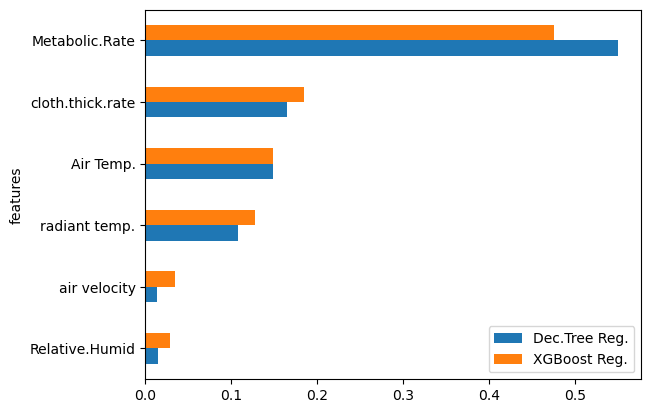

In [ ]:
# See the ML_model.feature_importances_
data_importance = pd.DataFrame({"features" : x.columns,
                                # "SV Reg.":coef_SVR,
                                "Dec.Tree Reg." : DT_reg.feature_importances_,
                                # "RandForest Reg.": RF_reg.feature_importances_,

                                "XGBoost Reg.":XG_reg.feature_importances_,
                                # "Linear Reg.":Lin_reg.coef_.flatten()
                                 }).sort_values('XGBoost Reg.', ascending = False).round(3)
data_importance.set_index('features').round(3).sort_values('XGBoost Reg.',ascending=True).plot(kind='barh')

In [ ]:
# Coefficient of Linear Regression and its Intercept
print( 'Linreg Coeff : ' + str (Lin_reg.coef_.round(3).flatten()) + '     and intercept: ' + str(Lin_reg.intercept_) )

Linreg Coeff : [ 0.134  0.1   -1.197  0.005  1.746  1.725]     and intercept: -9.178658697703478


In [ ]:
# Evaluate the models
test_prediction_result  = estimate_predictions(ML_model_list, ML_model_names, x_test, y_test, 'test')
train_prediction_result = estimate_predictions(ML_model_list, ML_model_names, x_train, y_train, 'train')
all_prediction_result   = estimate_predictions(ML_model_list, ML_model_names, x, y, 'All')
all_prediction_result   = x.reset_index(drop=True).join(all_prediction_result)

# SHAP

In [ ]:
# SPLIT TRAIN TEST DATA FOR EXPLANATION. we are going to use x_test only as the randomly-samples
x_train_shap, x_test_shap, y_train_shap, y_test_shap = train_test_split(x, y, train_size = ((98)/100),
                                                    shuffle = True, random_state= random_use )

In [ ]:
# EXPLAIN THE ML - XGBoost Regression
ML_shap = XG_reg  #DT_reg  #dont do it with DecisionTree. yesterday, it won't work. kernel will be destroyed / restarted!
x_test_shap2 = pd.DataFrame(variable_scale.inverse_transform(x_test_shap), columns=x.columns)

explainer = shap.Explainer(ML_shap, x_test_shap)
shap_values_tree = explainer(x_test_shap)
# EXPLAIN THE ML - Linear Regression
explainer_Lin = shap.LinearExplainer(Lin_reg, x_test_shap)
shap_values_Lin = explainer_Lin(x_test_shap)

 99%|===================| 12474/12614 [01:17<00:00]        

# Plotting

<Axes: ylabel='features'>

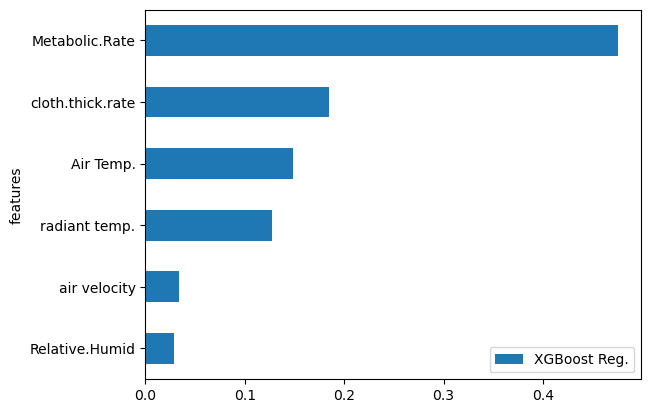

In [ ]:
data_importance[['features', 'XGBoost Reg.']].sort_values(by= 'XGBoost Reg.' ,ascending=True).set_index('features').round(3).plot(kind='barh')

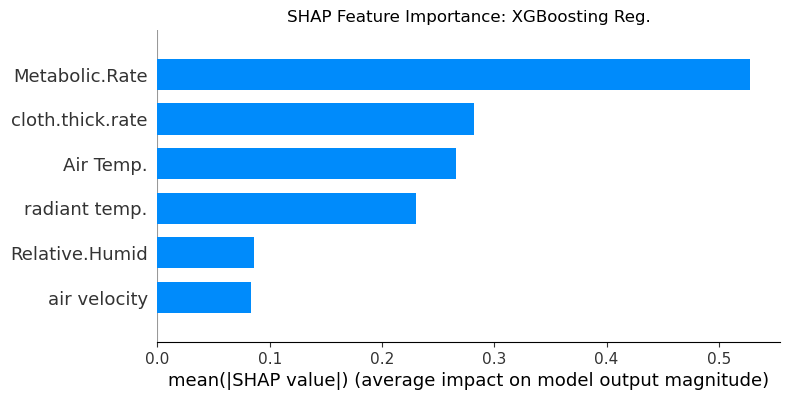

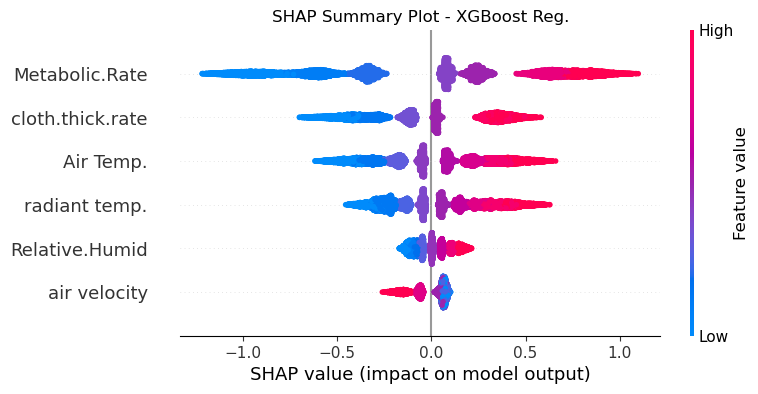

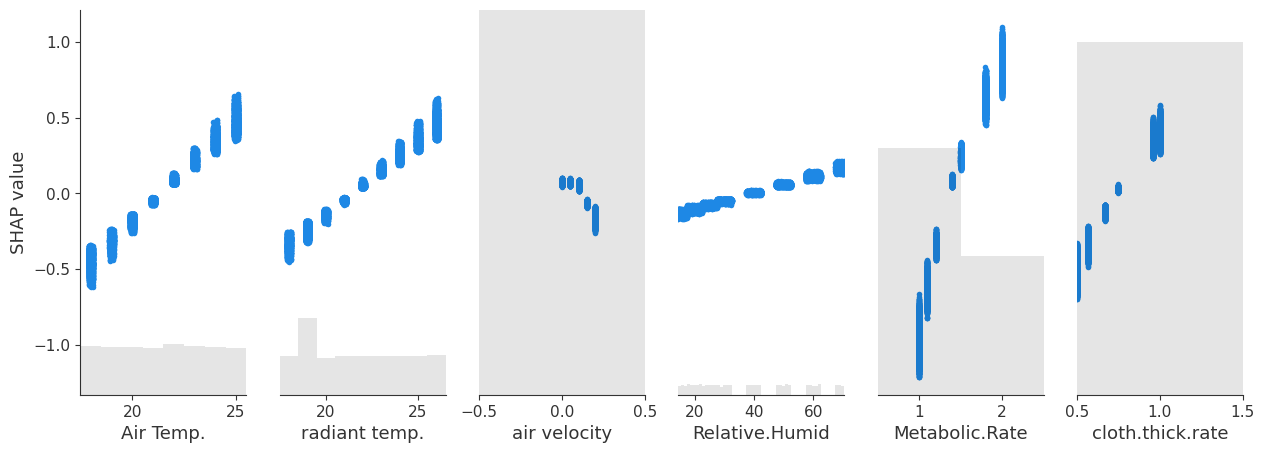

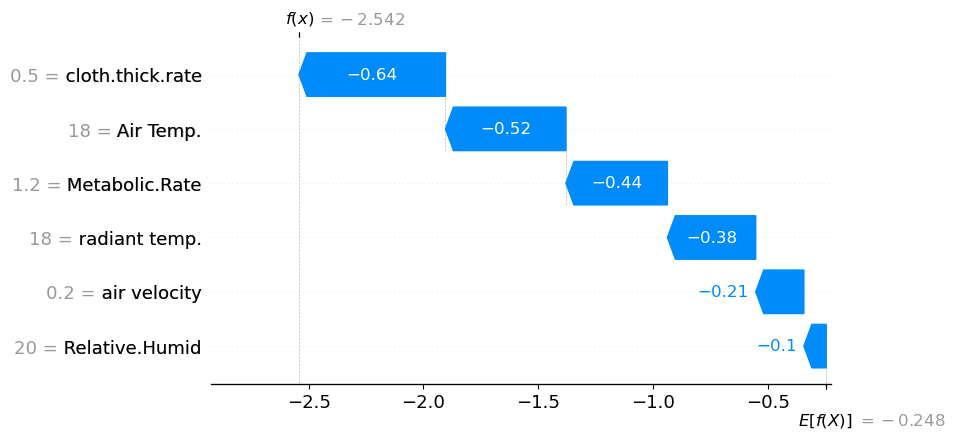

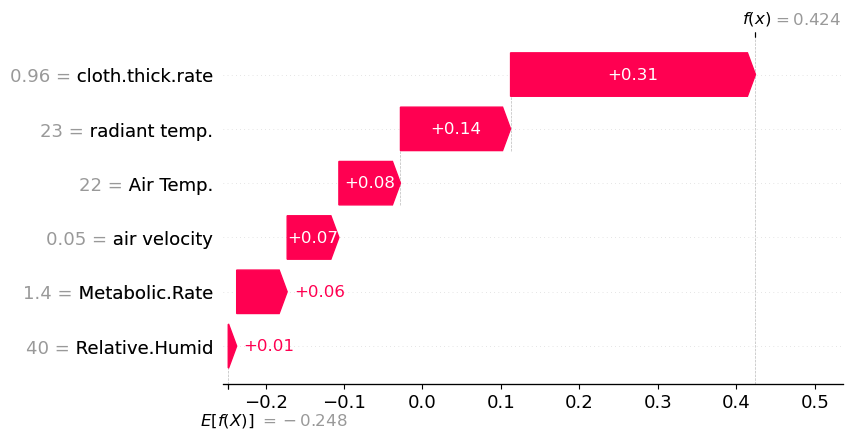

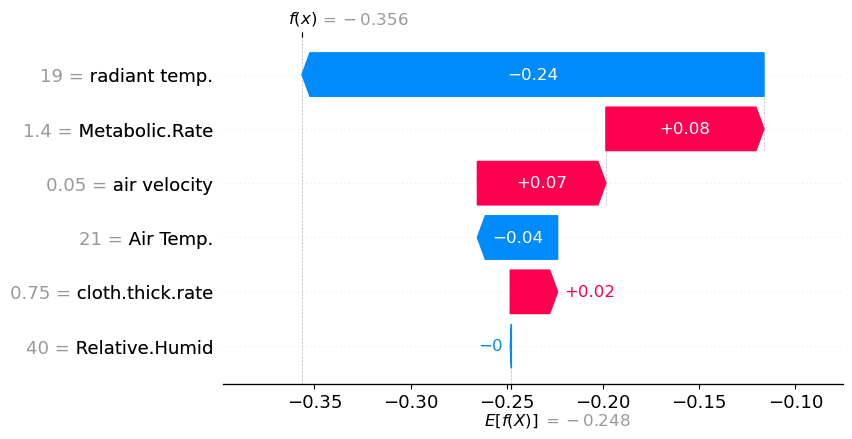

In [152]:
#my account
max_display = 6  #number of displayed features

# Bar plot to show the mean absolute SHAP value for each feature across all predictions
shap.summary_plot(shap_values_tree, x_test_shap, plot_type="bar", show=False, feature_names=x.columns)
plt.title('SHAP Feature Importance: XGBoosting Reg.')
plt.show()
# # Bar plot to show the mean absolute SHAP value for each feature across all predictions
# shap.summary_plot(shap_values_Lin, x_test_shap, plot_type="bar", show=False, feature_names=x.columns)
# plt.title('SHAP Feature Importance: Linear Reg.')
# plt.show()

shap.summary_plot(shap_values_tree, x_test_shap, plot_type="dot", show=False, feature_names=x.columns)
plt.title(f'SHAP Summary Plot - XGBoost Reg.')
plt.show()

# shap.summary_plot(shap_values_Lin, x_test_shap, plot_type="dot", show=False, feature_names=x.columns)
# plt.title(f'SHAP Summary Plot - Linear Reg.')
# plt.show()
shap.plots.scatter(shap_values_tree)
shap.plots.waterfall(shap_values_tree[-1000], max_display=max_display )
# shap.plots.waterfall(shap_values_Lin[-1000], max_display=max_display )
shap.plots.waterfall(shap_values_tree[-1], max_display=max_display )
# shap.plots.waterfall(shap_values_Lin[-1], max_display=max_display )
shap.plots.waterfall(shap_values_tree[-100], max_display=max_display )

In [ ]:
# shap.plots.heatmap(shap_values_exact)   #watchout, its too heavy for data more than thousands of rows
# shap.plots.heatmap(shap_values_Lin)   #watchout, its too heavy for data more than thousands of rows

SHAP (SHapley Additive Explanations) is a robust tool for interpreting machine learning models by assigning importance to features based on their contribution to predictions.
it shows the contribution of each feature to the prediction result in terms of its absolute contribution

Pros:
It ensures fair and consistent feature importance.
offer both global and local insights and can handle interactions between features.


Cons:
expensive computation! takes longer time. particularly for large datasets or models with many features.
Interpretation and understanding require a moderate level of expertise.

EXTRA : SHAP as a feature selection method (?)

now how if we eliminate air velocity and RH since they contribute less. (?) 

now we re-train data by using only : metabolic rate, cloth rate, mean radiant temperature, and air temperature.

In [148]:
x_new = x.drop(['Relative.Humid', 'air velocity'], axis=1)
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(x_new, y, train_size = (train_percent/100),
                                                    shuffle = True, random_state= random_use )

#TRAIN and see testing  : Linear Regression, Dec.Tree Regression and XGBoost Regression
Lin_reg_new = LinearRegression(fit_intercept=True)
Lin_reg_new.fit(x_train_new, y_train_new)
DT_reg_new = DecisionTreeRegressor(random_state=random_use)
DT_reg_new.fit(x_train_new, y_train_new)
XG_reg_new = XGBRegressor(random_state= random_use)
XG_reg_new.fit(x_train_new, y_train_new)
ML_model_list_new = [Lin_reg_new, DT_reg_new, XG_reg_new]
ML_model_names_new = ['Linear_new', 'DecTree_new', 'XGB_new']
regression_result_new  = evaluate_models_all(ML_model_list_new, ML_model_names_new, x_train_new, y_train_new, x_test_new, y_test_new).round(2)
regression_result_new

,ML Model,R2 train,R2 test,RMSE train,RMSE test
0,Linear_new,0.92,0.92,0.23,0.23
1,DecTree_new,0.97,0.97,0.14,0.14
2,XGB_new,0.97,0.97,0.14,0.14


<Axes: ylabel='features'>

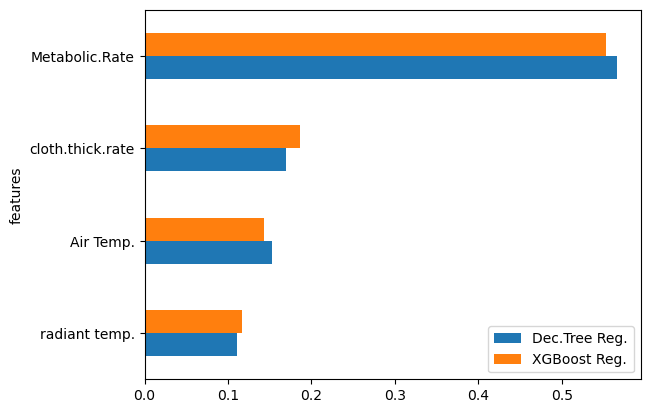

In [151]:
# See the ML_model.feature_importances_
data_importance_new = pd.DataFrame({"features" : x_new.columns,
                                # "SV Reg.":coef_SVR,
                                "Dec.Tree Reg." : DT_reg_new.feature_importances_,
                                # "RandForest Reg.": RF_reg.feature_importances_,

                                "XGBoost Reg.":XG_reg_new.feature_importances_,
                                # "Linear Reg.":Lin_reg.coef_.flatten()
                                 }).sort_values('XGBoost Reg.', ascending = False).round(3)
data_importance_new.set_index('features').round(3).sort_values('XGBoost Reg.',ascending=True).plot(kind='barh')